# Reference data-driven (RDD) metabolomics
## Dietary patterns: Vegan vs. Omnivore comparison

This notebook demonstrates the application of Reference data-driven (RDD) metabolomics to identify dietary signatures in human samples by comparing metabolite profiles between vegan and omnivore diets.

---

### Overview

**RDD metabolomics** quantifies shared molecular features between samples and reference databases across hierarchical ontology levels. By counting matches at different taxonomic levels, we can identify food-derived metabolites and reconstruct dietary patterns.

**Key concepts:**
- **RDD counts**: Number of shared molecular clusters between a sample and reference food categories
- **Ontology levels**: Hierarchical classification


**Dataset:**
- NIST human biological samples (vegan and omnivore participants)
- NIST food metabolomics reference library
- GNPS Molecular networking clustering output

---

## 1. Setup

Import the RDD package modules

In [1]:
# Import RDD package components
from rdd.RDDcounts import RDDCounts
from rdd.visualization import *
from rdd.analysis import *

# Standard visualization libraries
import matplotlib.pyplot as plt

---

## 2. Load GNPS data and generate RDD counts



The `RDDCounts` class performs several operations automatically:

1. **Load molecular networking data** from GNPS (or local file as fallback)
2. **Match molecular clusters** between samples and reference food database
3. **Generate counts** at all ontology levels (0-6)
4. **Organize results** into a structured dataframe

### Parameters:
- `task_id`: GNPS job identifier for automatic data retrieval
- `gnps_network_path`: Local backup file path
- `sample_types`: 'simple' uses single ingredient food items
- `sample_groups`: Sample identifiers in the GNPS metadata (e.g., ["G1"])
- `reference_groups`: Reference identifiers in the GNPS metadata (e.g., ["G4"])


In [2]:
# Define data source parameters
gnps_food_nist_task = "74089e95b8df41b2af7c289869dc866f"  # GNPS task ID
gnps_food_nist_path = "../data/sample_gnps_vegomn.tsv"              # Local file backup

# Attempt to load data from GNPS, fallback to local file if needed
try:
    rdd_food_nist = RDDCounts(
        task_id=gnps_food_nist_task,
        gnps_2=False,                    # Use GNPS classic (not GNPS2)
        sample_types="simple",           # Use simplified reference ontology
        sample_groups=["G1"],            # Sample group identifiers from GNPS
        reference_groups=["G4"],         # Reference group identifiers from GNPS
        ontology_columns=None            # Use default food ontology structure
    )
    print("✓ Successfully loaded data from GNPS")
except Exception as e:
    print(f"An error occurred accessing GNPS. Will load data from file instead.")
    rdd_food_nist = RDDCounts(
        gnps_network_path=gnps_food_nist_path,
        sample_types="simple",
        sample_groups=["G1"],
        reference_groups=["G4"],
        ontology_columns=None
    )

/home/amca2892/workspace/github.com/AlejandroMC28/gnps-rdd/venv_rdd/lib/python3.12/site-packages/gnpsdata/taskresult.py:43: XMLParsedAsHTMLWarning: It looks like you're using an HTML parser to parse an XML document.

Assuming this really is an XML document, what you're doing might work, but you should know that using an XML parser will be more reliable. To parse this document as XML, make sure you have the Python package 'lxml' installed, and pass the keyword argument `features="xml"` into the BeautifulSoup constructor.

If you want or need to use an HTML parser on this document, you can make this warning go away by filtering it. To do that, run this code before calling the BeautifulSoup constructor:

    from bs4 import XMLParsedAsHTMLWarning
    import warnings

    warnings.filterwarnings("ignore", category=XMLParsedAsHTMLWarning)

  soup = BeautifulSoup(r.text, 'html.parser')


✓ Successfully loaded data from GNPS


### Inspect the RDD counts data

The RDD `counts` is a long dataframe that contains:
- **filename**: Sample identifier
- **reference_type**: Food category or specific reference name (depends on level)
- **count**: Number of shared molecular features between sample and reference
- **level**: Ontology hierarchy level (1 = most general, higher = more specific, level 0 refers to file-level counts)
- **group**: Sample group label (currently generic from GNPS job, will be updated next)

In [3]:
# Display first few rows of RDD counts
rdd_food_nist.counts.head()

,filename,reference_type,count,level,group
0,NIST_POS_Samp_07-01,11442.G72441,9,0,G1
1,NIST_POS_Samp_07-01,11442.G72442,22,0,G1
2,NIST_POS_Samp_07-01,11442.G72443,34,0,G1
3,NIST_POS_Samp_07-01,11442.G72444,26,0,G1
4,NIST_POS_Samp_07-01,11442.G72445,14,0,G1


---

## 3. Update Sample Groups with Diet Labels

Replace generic group identifiers (G1, G4) with meaningful labels (Vegan, Omnivore).

### Metadata File Requirements:
The CSV file should contain:
- `filename`: Sample identifiers matching those in the RDD counts
- `new_group`: Diet classification (e.g., "Vegan", "Omnivore")

This step updates both the counts dataframe and the internal sample metadata.

In [4]:
# Update group labels from external metadata file
rdd_food_nist.update_groups(
    "../data/demo_gnps_metadata.csv",
    merge_column='new_group'
)
print("✓ Group labels updated successfully")
rdd_food_nist.counts.head()

✓ Group labels updated successfully


,filename,reference_type,count,level,group
0,NIST_POS_Samp_07-01,11442.G72441,9,0,Omnivore
1,NIST_POS_Samp_07-01,11442.G72442,22,0,Omnivore
2,NIST_POS_Samp_07-01,11442.G72443,34,0,Omnivore
3,NIST_POS_Samp_07-01,11442.G72444,26,0,Omnivore
4,NIST_POS_Samp_07-01,11442.G72445,14,0,Omnivore


---

## 4. Filtering RDD counts: Example

The `filter_counts()` method allows subsetting the data by:
- **level**: Specific ontology hierarchy level
- **reference_types**: List of specific food categories to include
- **top_n**: Automatically select top N references by count (optional)

### Example: Apple counts at level 5

Level 5 represents specific food items. Here we examine RDD counts for "apple" across all samples, grouped by diet type.

In [5]:
# Example: Filter for apple references at level 5 (specific food level)
apple_counts = rdd_food_nist.filter_counts(
    level=5,
    reference_types=["apple"]
)

# Display the filtered results
apple_counts.head()

,filename,reference_type,count,level,group
129312,NIST_POS_Samp_07-01,apple,118,5,Omnivore
129313,NIST_POS_Samp_07-02,apple,89,5,Omnivore
129314,NIST_POS_Samp_07-03,apple,101,5,Omnivore
129315,NIST_POS_Samp_08-01,apple,111,5,Omnivore
129316,NIST_POS_Samp_08-02,apple,104,5,Omnivore


These counts represent the number of molecular features in each sample that match apple reference spectra. Higher counts suggest greater apple consumption or presence of apple-derived metabolites.

---

## 5. Visualization: Food category proportions

### Objective
Compare RDD count proportions for major food categories between vegan and omnivore groups.


### Food categories (Level 3)
We examine broad food groups:
- **vegetable/herb**: Plant-based vegetables and herbs
- **seafood**: Fish and marine products
- **dairy**: Milk and dairy products
- **meat**: Animal flesh products
- **fleshy fruit**: Fruits with soft pulp
- **legume**: Beans, peas, lentils

### Expected patterns
- **Vegan**: Higher plant-based categories (vegetables, fruits, legumes)
- **Omnivore**: Higher animal product categories (dairy, meat, seafood)

/tmp/ipykernel_435028/2066313885.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[idx].set_xticklabels(axes[idx].get_xticklabels(), ha='center')
/tmp/ipykernel_435028/2066313885.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[idx].set_xticklabels(axes[idx].get_xticklabels(), ha='center')
/tmp/ipykernel_435028/2066313885.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[idx].set_xticklabels(axes[idx].get_xticklabels(), ha='center')
/tmp/ipykernel_435028/2066313885.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[idx].set_xticklabels(axes[idx].get_xticklabels(), ha='center')
/tmp/ipykernel_435028/2066313885.py:27: UserWarn

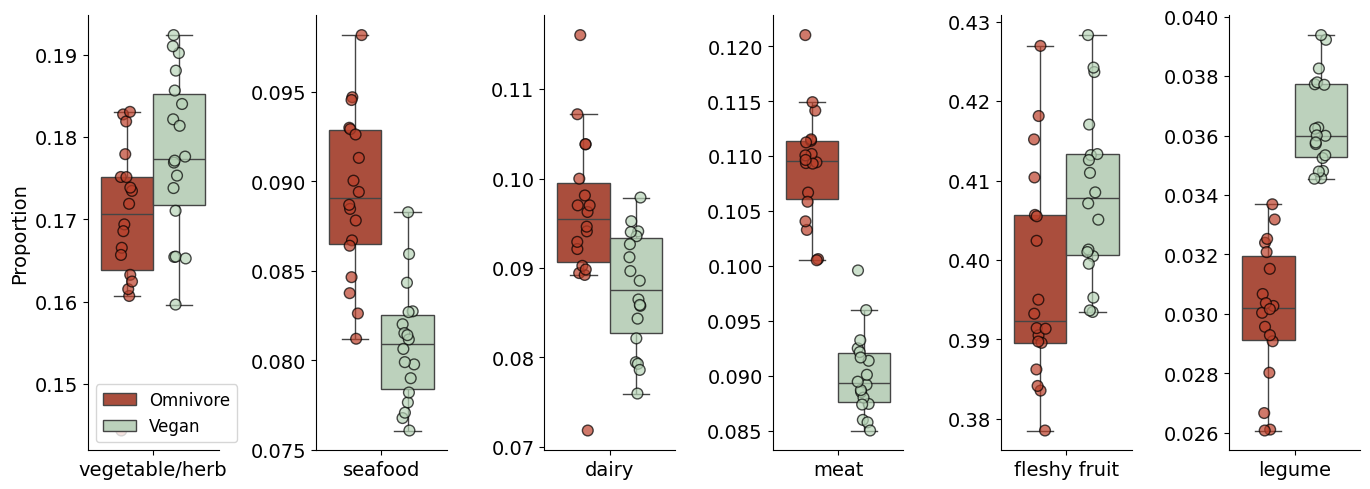

In [6]:
# Initialize visualizer with matplotlib backend
visualizer = Visualizer(MatplotlibBackend())

# Define food categories to compare (level 3 = broad categories)
references = ["vegetable/herb", "seafood", "dairy", "meat", "fleshy fruit", "legume"]
level = 3

# Create multi-panel figure
fig, axes = plt.subplots(1, len(references), figsize=(2.3 * len(references), 5))

# Generate boxplot for each food category
for idx, reference in enumerate(references):
    # Plot RDD proportions grouped by diet type
    visualizer.box_plot_RDD_proportions(
        rdd_food_nist, 
        level=level, 
        group_by=True, 
        reference_types=[reference],
        ax=axes[idx],
        group_colors={"Vegan": "#B8D5B8", "Omnivore": "#BC412B"}  # Custom colors
    )
    
    # Customize subplot appearance
    axes[idx].spines['top'].set_visible(False)
    axes[idx].spines['right'].set_visible(False)
    axes[idx].tick_params(axis='x', labelsize=14, rotation=0)
    axes[idx].set_xticklabels(axes[idx].get_xticklabels(), ha='center')
    axes[idx].tick_params(axis='y', labelsize=14)
    
    # Style scatter point overlays
    for marker in axes[idx].collections[:2]:
        marker.set_edgecolor('black')
        marker.set_linewidth(1)
        marker.set_sizes([60])
    
    # Remove titles and x-labels for cleaner look
    axes[idx].set_title("")
    axes[idx].set_xlabel("")
    
    # Y-axis label only on first subplot
    if idx == 0:
        axes[idx].set_ylabel("Proportion", fontsize=14)
        axes[idx].legend(fontsize=12, loc='best')
    else:
        axes[idx].set_ylabel("")  # Keep independent y-scales
        # Remove redundant legends
        legend = axes[idx].get_legend()
        if legend:
            legend.remove()

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

- **Dairy, meat & seafood**: Higher in omnivore samples (animal product consumption).
- **Vegetable/Herb, legume and fleshy fruit**: Higher in vegan samples (plant-based diet).


- Clear separation indicates distinct dietary patterns

---

## 6. Principal Component Analysis (PCA)

### Objective
Reduce high-dimensional RDD count data to visualize overall sample relationships and identify clustering by diet group.


Centered log-ratio transformation for compositional data.


### Level selection
- **Level 0** (used here): Individual reference files - highest resolution.

### Expected outcome
If dietary metabolic signatures are distinct, vegan and omnivore samples should separate along principal components.

In [7]:
# Perform PCA on RDD counts at level 0 (file-level)
pca_df, explained_variance = perform_pca_RDD_counts(
    rdd_food_nist,
    level=0,
    n_components=3,
    apply_clr=True  # Apply centered log-ratio transformation
)

# Display variance explained by each component
print("PCA Variance Explained:")
print(f"  PC1: {100*explained_variance[0]:.2f}%")
print(f"  PC2: {100*explained_variance[1]:.2f}%")
print(f"  PC3: {100*explained_variance[2]:.2f}%")
print(f"\n  Cumulative (PC1+PC2): {100*sum(explained_variance[:2]):.2f}%")

PCA Variance Explained:
  PC1: 34.44%
  PC2: 12.21%
  PC3: 11.27%

  Cumulative (PC1+PC2): 46.65%


### Visualize PCA Results

The scatter plot shows sample positions in the reduced dimensional space, with colors indicating diet groups.

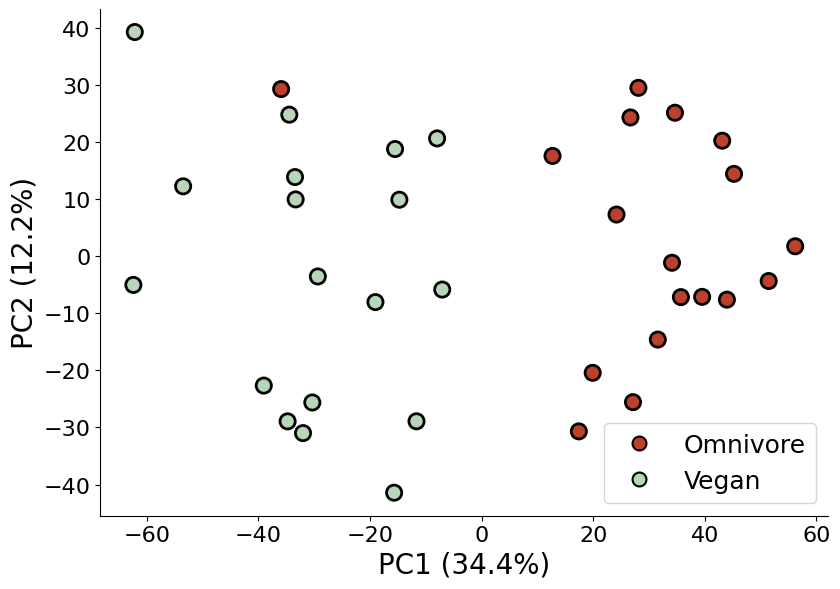

In [8]:
# Initialize visualizer
visualizer = Visualizer(MatplotlibBackend())

# Define custom color palette
custom_palette = {"Vegan": "#B8D5B8", "Omnivore": "#BC412B"}

# Create PCA scatter plot
fig = visualizer.plot_pca_results(
    pca_df,
    explained_variance,
    group_colors=custom_palette,
    figsize=(8.5, 6)
) 

ax = fig.axes[0]

# Customize plot styling
ax.set_title("")  # Remove default title
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)

# Set axis labels with variance explained
ax.set_xlabel(f"PC1 ({100*explained_variance[0]:.1f}%)", fontsize=20)
ax.set_ylabel(f"PC2 ({100*explained_variance[1]:.1f}%)", fontsize=20)
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)

# Enhance legend appearance
ax.legend(fontsize=18)

# Style scatter points
for collection in ax.collections:
    collection.set_sizes([120])      # Increase point size
    collection.set_edgecolor('black') # Add black edge
    collection.set_linewidth(2.0)     # Set edge width

# Style legend markers
legend = ax.get_legend()
for handle in legend.legend_handles:
    handle.set_markersize(10)
    handle.set_markeredgewidth(1.5)
    handle.set_markeredgecolor('black')

# Remove top and right spines for cleaner look
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()

# Save as high-resolution vector graphic
#plt.savefig("pca_results.svg", dpi=400, bbox_inches='tight', format='svg')

plt.show()

### PCA

**Clear group separation:**
- Shows distinct metabolic profiles between diets
- PC1 captures the primary dietary distinction (plant vs. animal products)

---

## 7. Sankey Diagram: Hierarchical Food Flows

### Objective
Visualize how RDD counts flow through the hierarchical food ontology, showing relationships between broad categories and specific food types.


- **Node Width**: Proportional to total RDD counts at that ontology level
- **Flow Thickness**: Shows distribution of counts from general to specific categories
- **Colors**: Represent different food ontology branches (if color mapping provided)

### Parameters
- `max_hierarchy_level=3`: Show up to level 3 (broad food categories)
- `color_mapping_file`: Optional CSV defining colors for each ontology branch
- `sample`: Optional sample file can be selected to only visualize the counts for one sample


In [9]:
# Initialize visualizer with Plotly backend for interactive diagrams
visualizer = Visualizer(PlotlyBackend())

# Generate interactive Sankey diagram
visualizer.plot_sankey(
    rdd_food_nist,
    color_mapping_file=r"/home/amca2892/workspace/github.com/AlejandroMC28/gnps-rdd/rdd/data/sample_type_hierarchy.csv",
    max_hierarchy_level=3
)

**Interactive features:**
- Hover over nodes and flows for exact count values
- Click and drag to rearrange for better visibility
- Use zoom controls for detailed examination

---

## 8. Summary

### Analysis workflow completed

✅ **Data loading**: Successfully retrieved GNPS molecular networking data  
✅ **RDD generation**: Computed counts across all ontology levels  
✅ **Group assignment**: Updated samples with diet classifications  
✅ **Proportional analysis**: Visualized food category differences between groups  
✅ **Multivariate analysis**: Revealed metabolic clustering by diet in PCA  
✅ **Hierarchical visualization**: Illustrated food relationships in Sankey diagram  


## References and resources

**Tools and Databases:**
- GNPS: https://gnps.ucsd.edu/
- RDD Package: [https://github.com/bittremieux-lab/gnps-rdd]

**Citation:**
If you use this workflow in your research, please cite:
```
[publication link]
```

---

**Notebook Information**  
Created: 2025  
Contact: [alejandro.mendozacantu@uantwerpen.be]